# CSC 245 Project Jhon Guzman John Mayuga Mohammad Bazrouk


Used Cars Dataset: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

In [1]:
import boto3
from io import StringIO
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import f_regression, SelectKBest
from scipy.stats import uniform, truncnorm, randint

from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae
from joblib import dump, load

from sklearn.ensemble import RandomForestRegressor

Read CSV File that is stored in an Amazon S3 bucket

In [2]:
s3 = boto3.client('s3')

In [3]:
csv_file_name = 'usedcars2.csv'
bucket_name = 'csc245'

In [4]:
try:
    obj = s3.get_object(Bucket=bucket_name, Key=csv_file_name)
    df = pd.read_csv(obj['Body'])
    print(f'{"usedcars2"} loaded from {"csc245"} successfully.')
    # Use the 'df' DataFrame for further data processing and analysis
except FileNotFoundError:
    print(f'{"usedcars2"} not found in {"csc245"}.')

usedcars2 loaded from csc245 successfully.


In [5]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state,lat,long
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN


In [6]:
df.info()
df.nunique(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   transmission  424324 non-null  object 
 9   drive         296313 non-null  object 
 10  size          120519 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
 13  state         426880 non-null  object 
 14  lat           420331 non-null  float64
 15  long          420331 non-null  float64
dtypes: float64(4), int64(1), object(11)
memory usage: 52.1+ MB


price            15655
year               114
manufacturer        42
model            29667
condition            6
cylinders            8
fuel                 5
odometer        104870
transmission         3
drive                3
size                 4
type                13
paint_color         12
state               51
lat              53181
long             53772
dtype: int64

In [7]:
df.describe()

,price,year,odometer,lat,long
count,4.268800e+05,425675.000000,4.224800e+05,420331.000000,420331.000000
mean,7.519903e+04,2011.235191,9.804333e+04,38.493940,-94.748599
std,1.218228e+07,9.452120,2.138815e+05,5.841533,18.365462
min,0.000000e+00,1900.000000,0.000000e+00,-84.122245,-159.827728
25%,5.900000e+03,2008.000000,3.770400e+04,34.601900,-111.939847
50%,1.395000e+04,2013.000000,8.554800e+04,39.150100,-88.432600
75%,2.648575e+04,2017.000000,1.335425e+05,42.398900,-80.832039
max,3.736929e+09,2022.000000,1.000000e+07,82.390818,173.885502


In [8]:
df = df.drop(columns=['lat','long'])

# Data Visualization

/tmp/ipykernel_21469/444587821.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

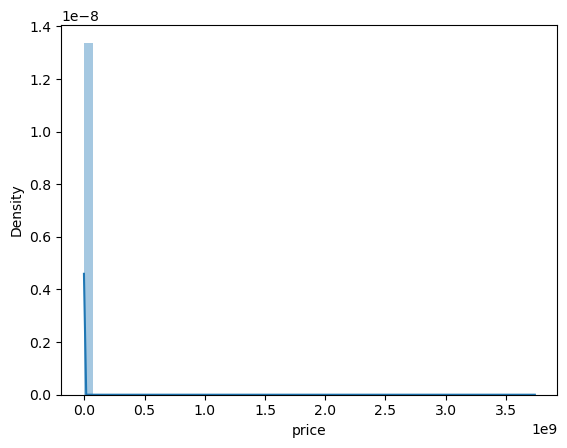

In [9]:
sns.distplot(df['price'])

<AxesSubplot: title={'center': 'Box Whisker Plot to Identify Outliers in Prices'}, xlabel='price'>

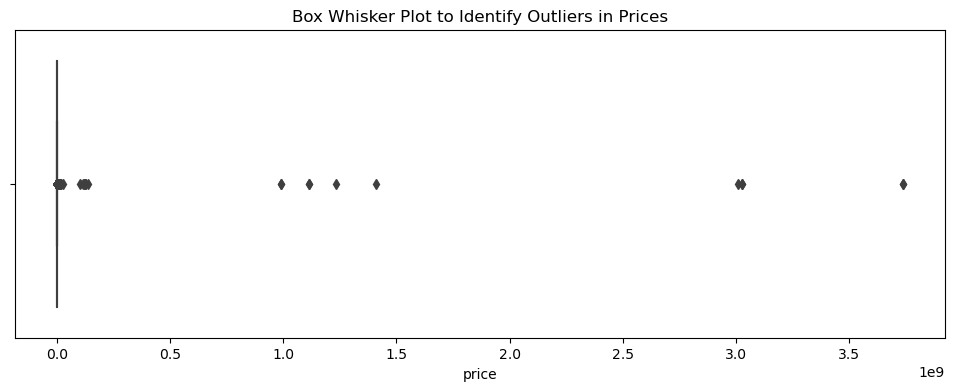

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title('Box Whisker Plot to Identify Outliers in Prices')
sns.boxplot(x= df['price'])


We can identify outliers from the skewed values on the left and right of the graph. Some of these extreme values make it even harder to see the remainder of the values. We remove these outliers by using the interquartile range. These extreme values are possible because the data is scraped from real-world entries where typos in the entries are likely.

In [11]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3-Q1

filtered_df = (df['price'] >= Q1 - 1.5 * IQR)  & (df['price'] <= Q3 + 1.5 * IQR)

old_size = df.count()['price']
df = df.loc[filtered_df]
new_size = df.count()['price']
print(old_size-new_size, '(', '{:.2f}'.format(100*(old_size-new_size)/old_size), '%',')', 'outliers removed from dataset')

8177 ( 1.92 % ) outliers removed from dataset


/tmp/ipykernel_21469/444587821.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

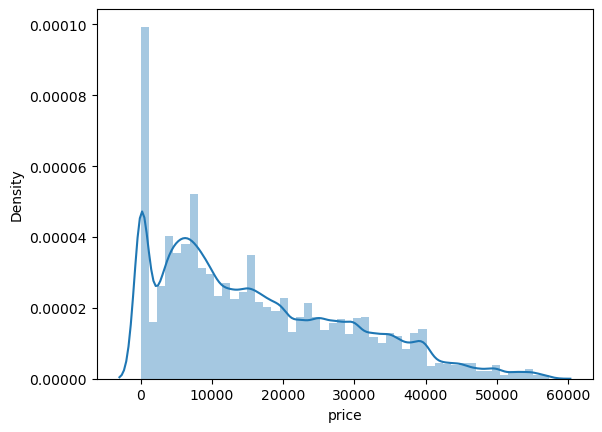

In [12]:
sns.distplot(df['price'])

The odometer also has outliers. Similar to the outliers in price, this could be a result of typing errors or simply mistakes in the samples. Lesser mileage is a possibility and so are higher mileages.

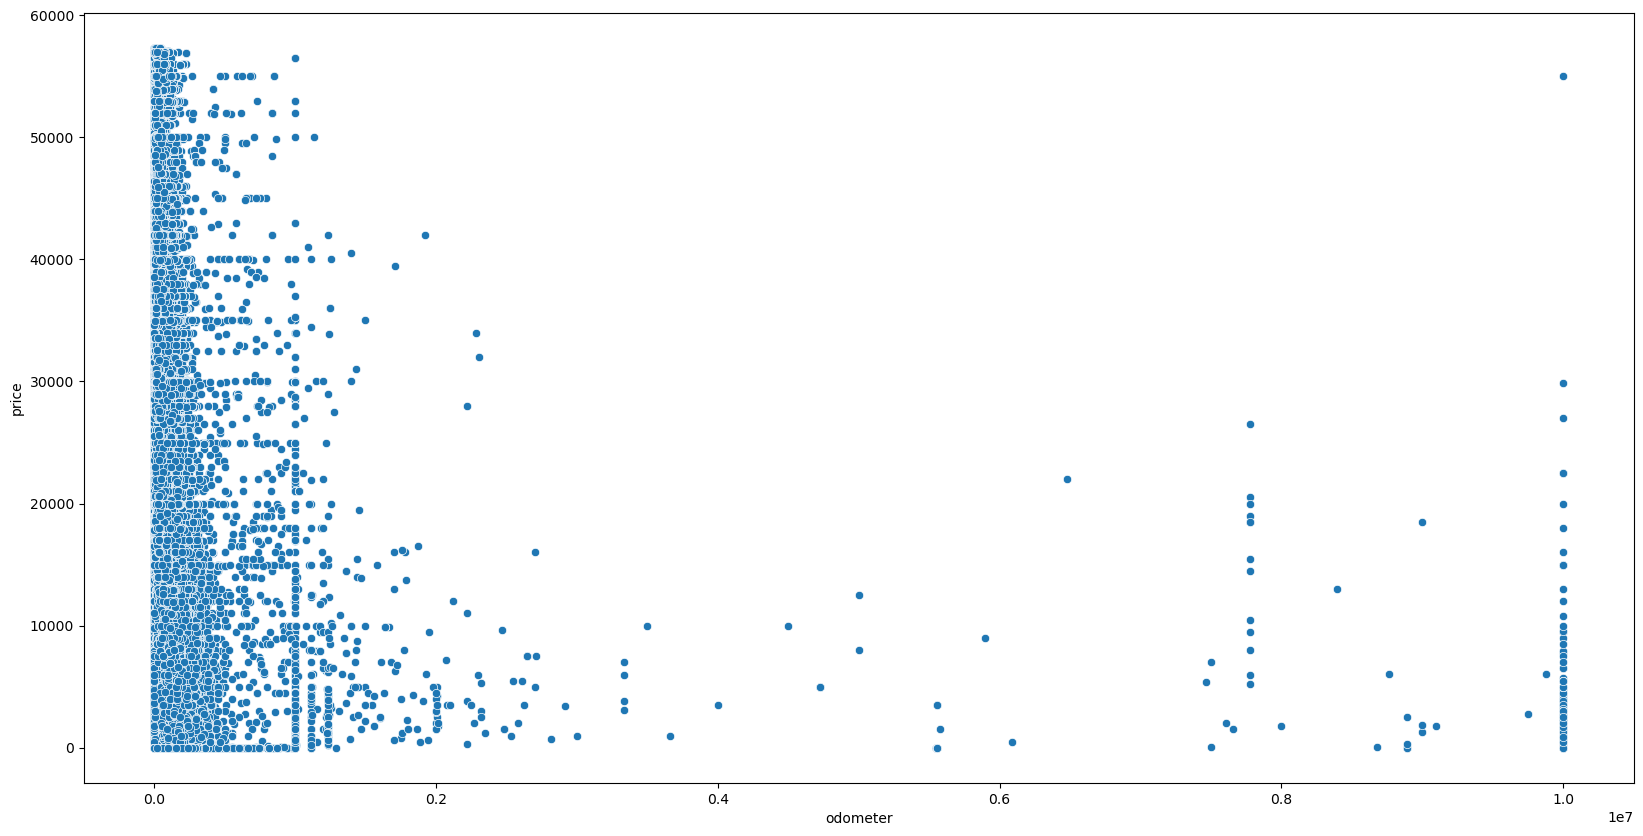

In [13]:
plt.figure(figsize=(20,10))
ax.set_title('Box Whisker Plot to Identify Outliers in Odometer')
ax = sns.scatterplot(x=df['odometer'], y=df['price'])

<AxesSubplot: title={'center': 'Box Whisker Plot to Identify Outliers in Odometer'}, xlabel='odometer'>

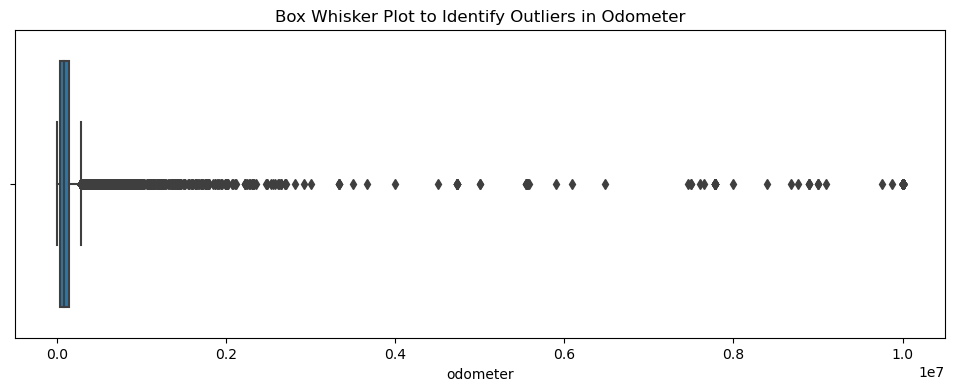

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title('Box Whisker Plot to Identify Outliers in Odometer')
sns.boxplot(x= df['odometer'])

In [15]:

Q1 = df['odometer'].quantile(0.25)
Q3 = df['odometer'].quantile(0.75)
IQR = Q3-Q1

filtered_df = (df['odometer'] <= Q3 + 3 * IQR)

old_size = df.count()['odometer']
df = df.loc[filtered_df]
new_size = df.count()['odometer']
print(old_size-new_size, '(', '{:.2f}'.format(100*(old_size-new_size)/old_size), '%',')', 'outliers removed from dataset')

1531 ( 0.37 % ) outliers removed from dataset


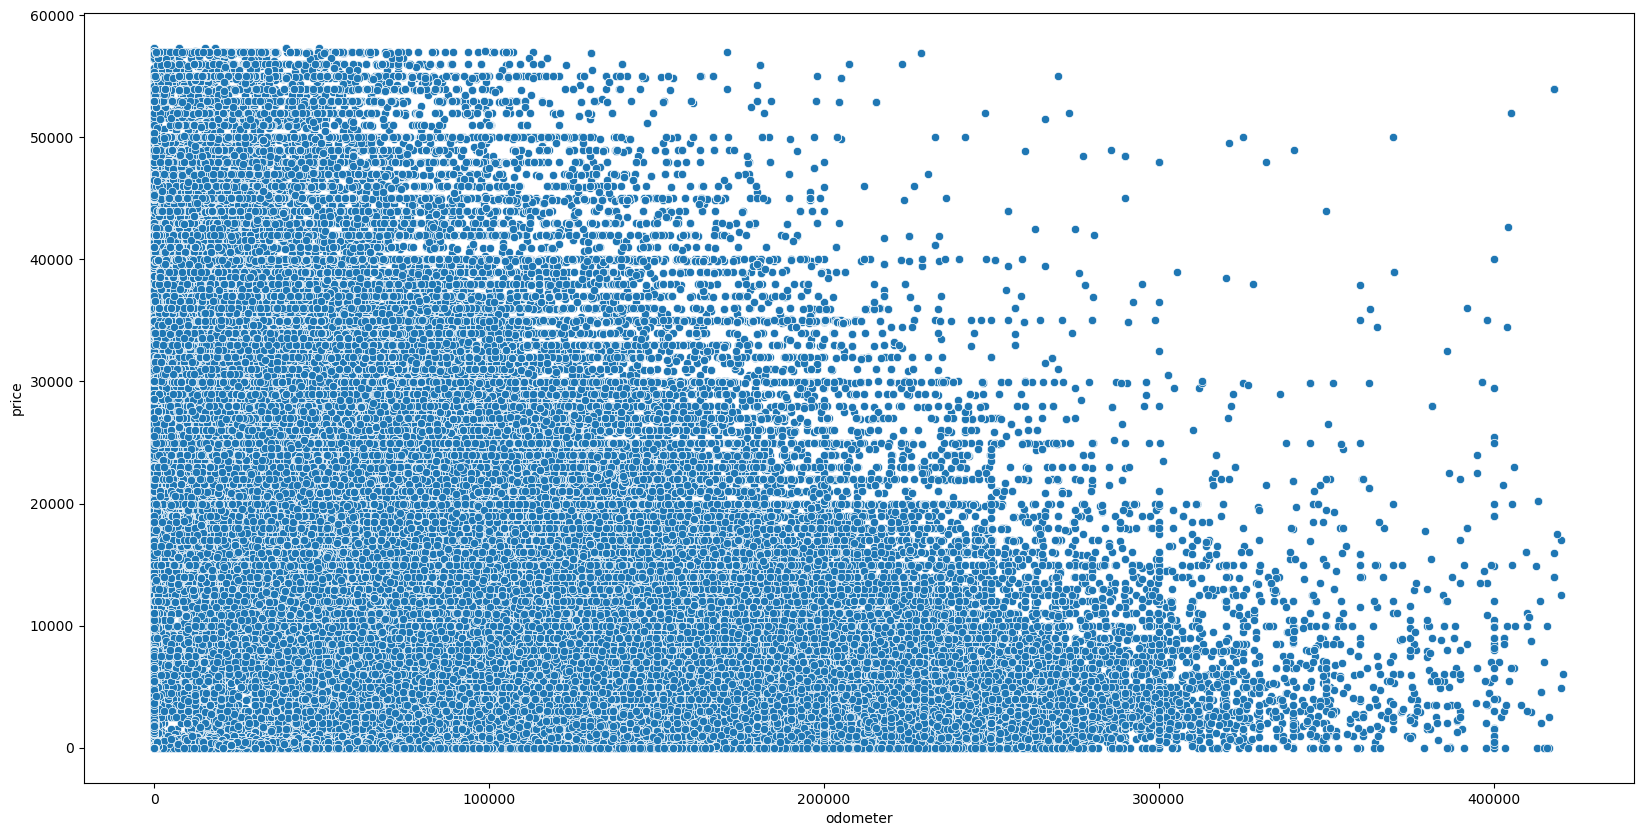

In [16]:
plt.figure(figsize=(20,10))
ax.set_title('Box Whisker Plot to Identify Outliers in Odometer')
ax = sns.scatterplot(x=df['odometer'], y=df['price'])

/tmp/ipykernel_21469/178632193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['odometer'])


<AxesSubplot: xlabel='odometer', ylabel='Density'>

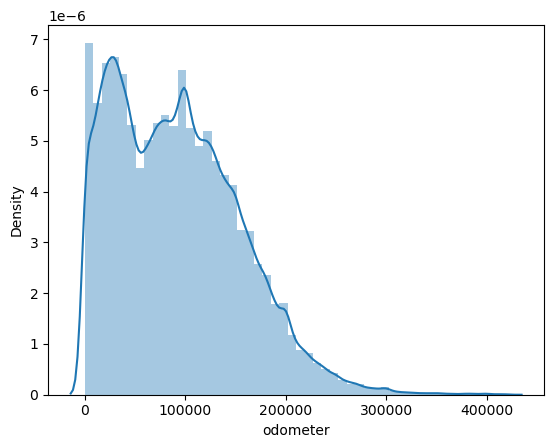

In [17]:
sns.distplot(df['odometer'])

We can observe an inverse relationship whereby cars with higher mileage cost less and vice versa. This makes sense in the real world. While there are many cars that were sold for free and have 0 mileage, we will keep these values because there may be exceptional situations in the the real world where used/new cars are given for free / for very little (who wouldn't want to live in a world like this). This also allows us to cater for a variety of cases and to prevent overfitting our model. We will narrow the dataset simply by focusing on removing the extreme values that skew the dataset.

We also want to set our range for the year to the last 50 years (1970-2020) to minimise the instability in the prices. Cars that were bought earlier than 50 years ago may no longer be representative of the market today because some of them may even be considered collectibles. After narrowing this range, we can observe a positive correlation between the year and the price.

In [18]:
df = df[df['year'].between(1970,2021)]

/tmp/ipykernel_21469/365097054.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['year'])


<AxesSubplot: xlabel='year', ylabel='Density'>

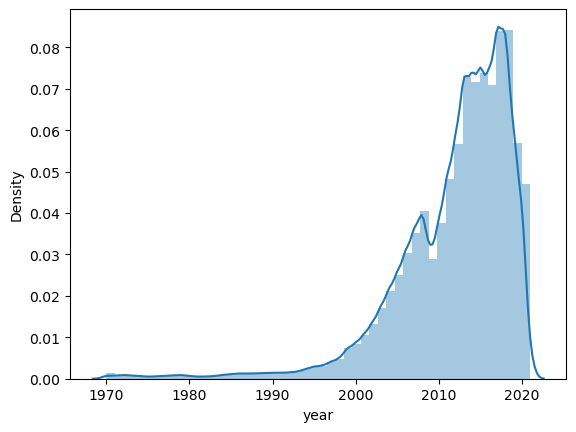

In [19]:
sns.distplot(df['year'])


<AxesSubplot: xlabel='year', ylabel='odometer'>

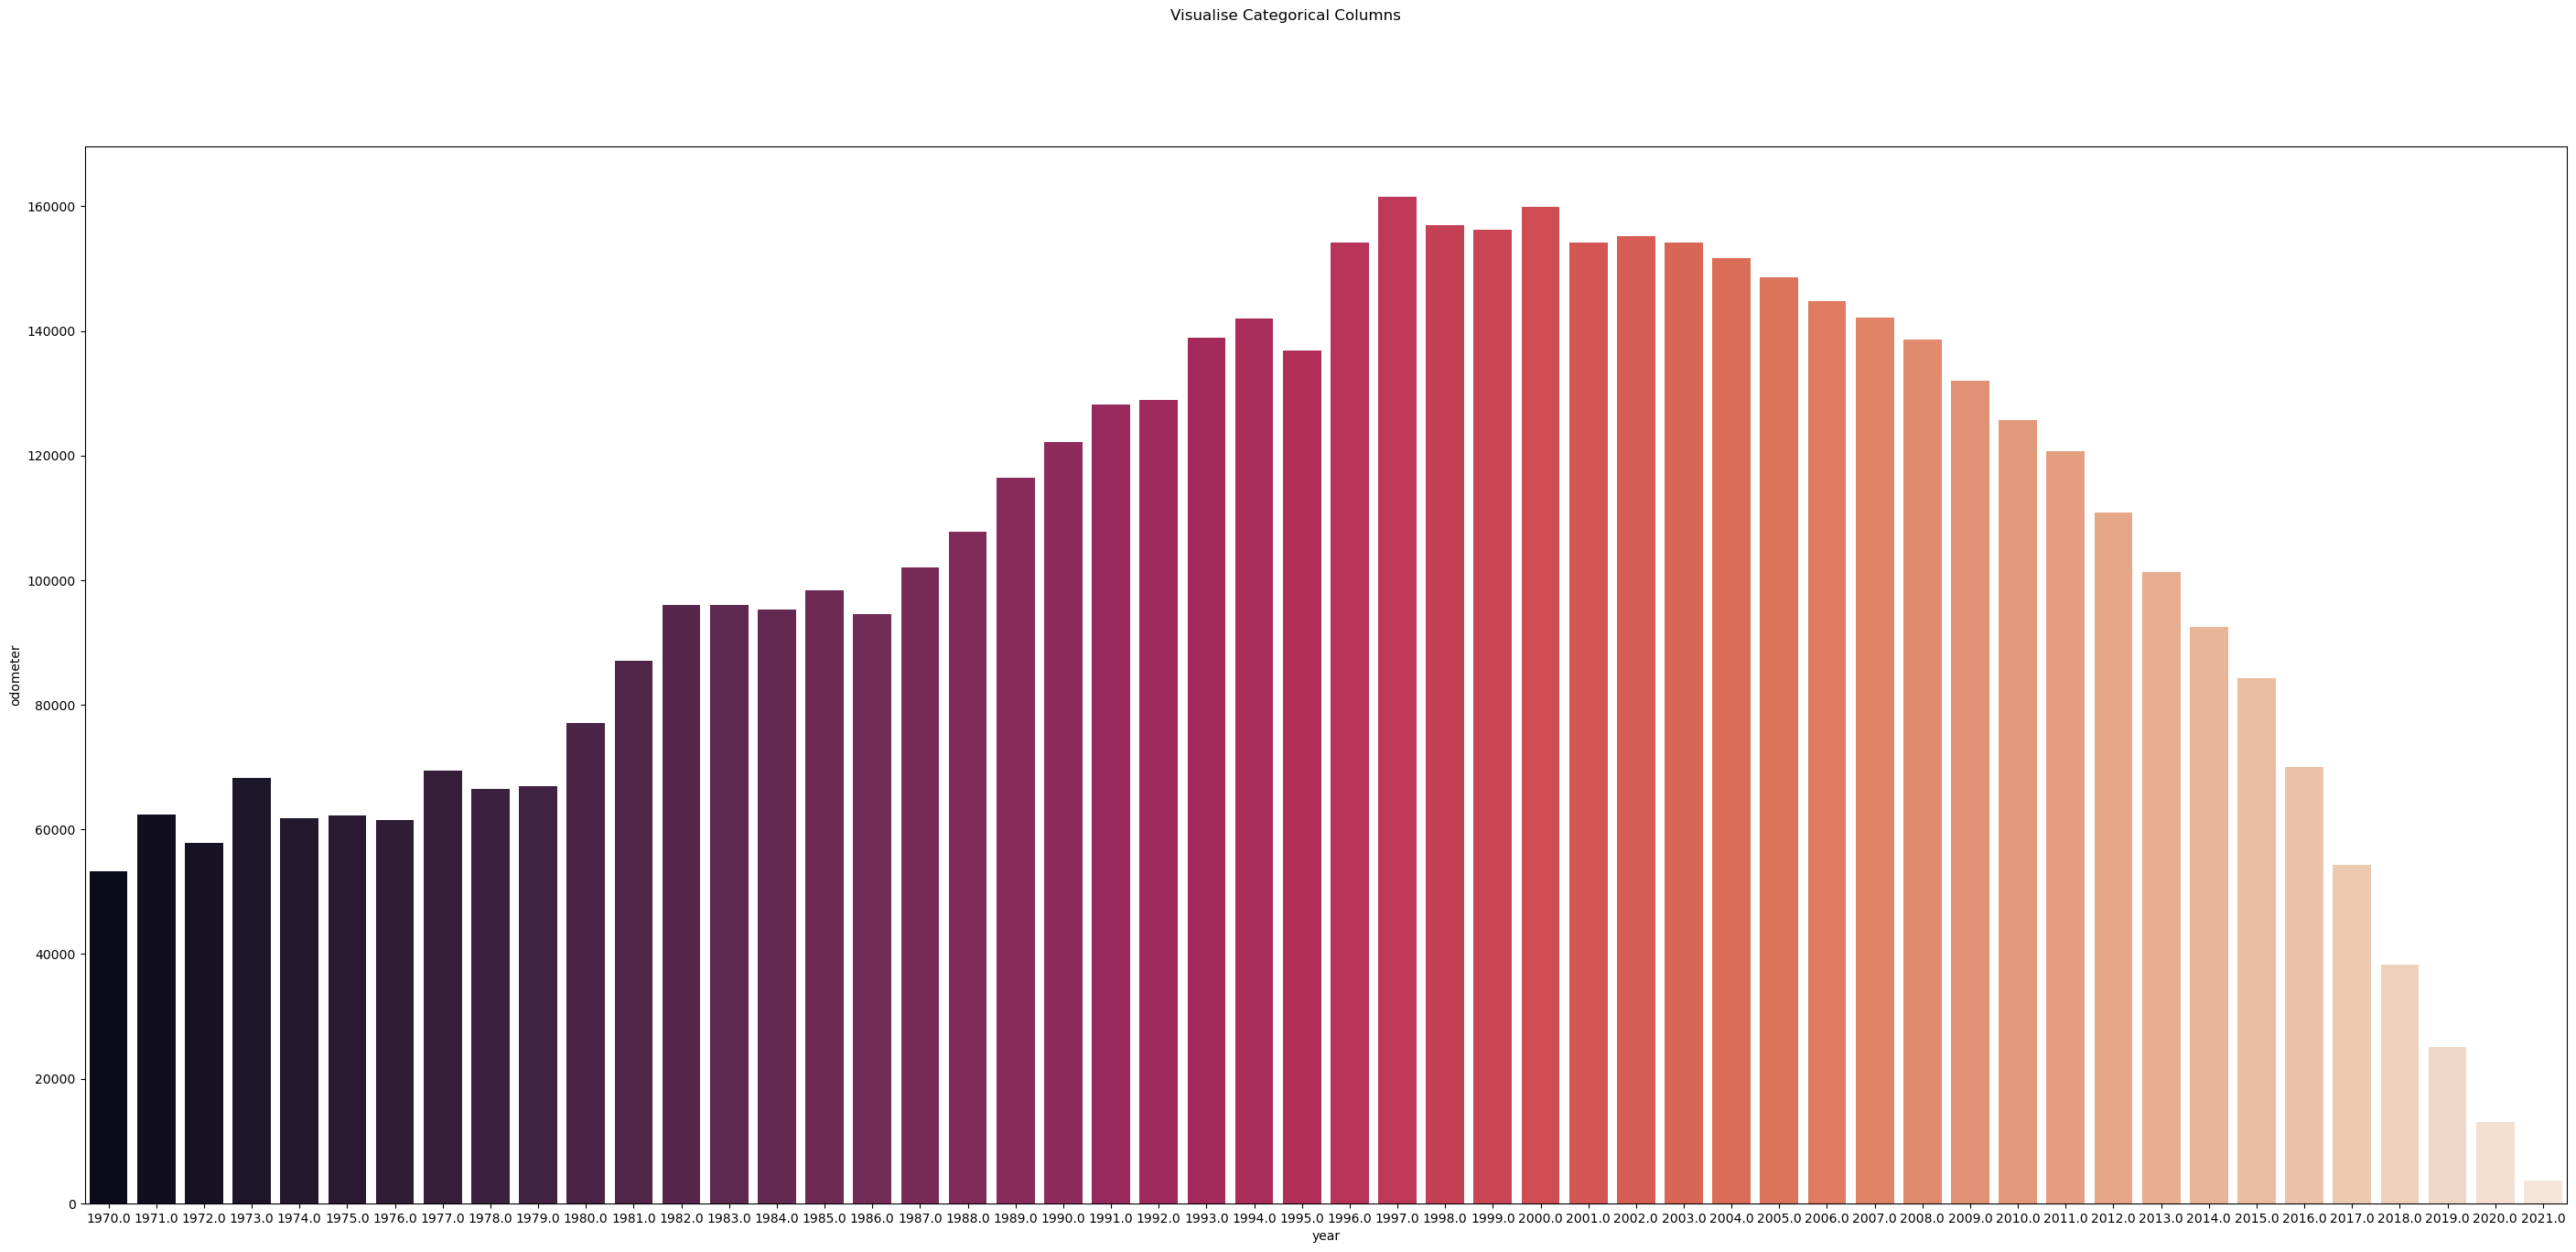

In [20]:
fig, ax = plt.subplots(figsize=(35,15), sharey=True)
fig.suptitle('Visualise Categorical Columns')
sns.barplot(x= df['year'], y=df['odometer'], errorbar=None, palette='rocket')

There seems to be a correlation between year and odometer, likely because the older cars would increase in mileage as the years increased but newer model cars have not cumulated as much mileage. While we can deep dive into whether this colinearity affects our model by calculating the Variance Inflation Factors (VIF), and if severe enough then we will have to drop one of the two variables but for the purposes of this project, we will assume that the VIF values are within acceptable bounds.

Next, we can summarise and visualise the categorical variables to understand their relationship with the target variable.

<AxesSubplot: xlabel='transmission', ylabel='price'>

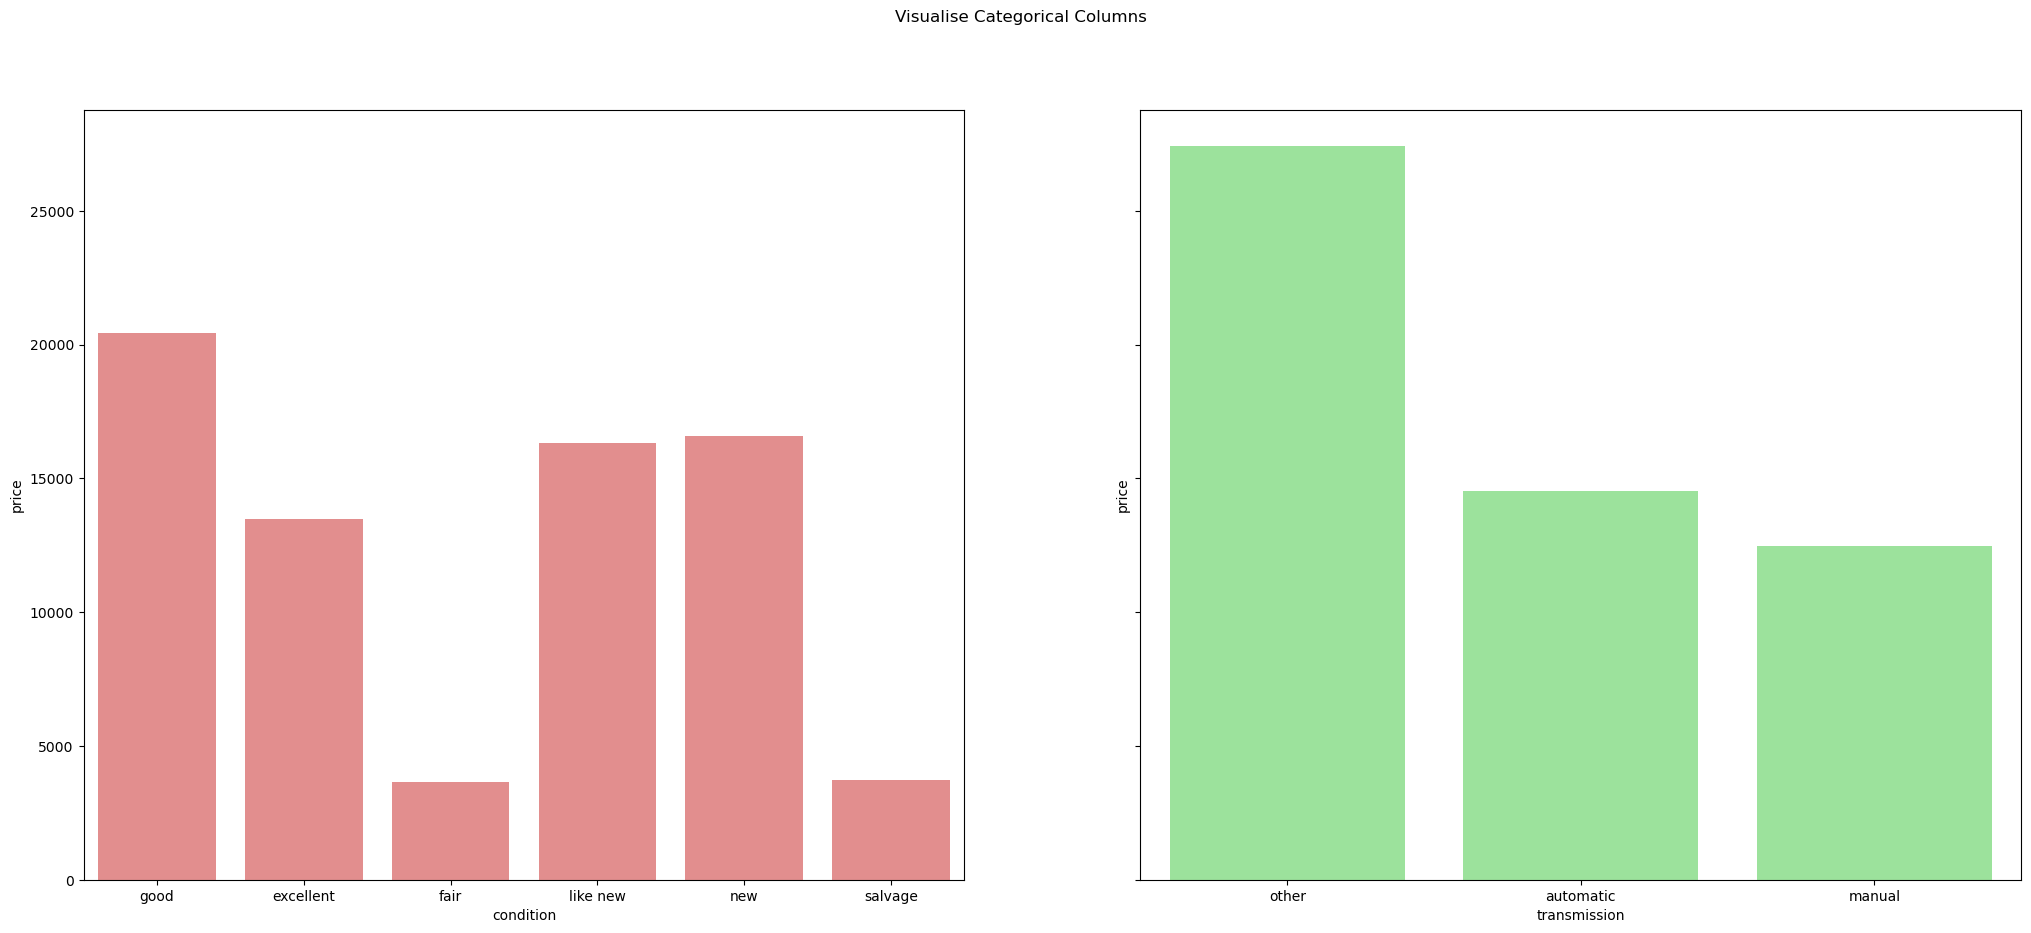

In [21]:
fig, axes = plt.subplots(1,2,figsize=(25,10), sharey=True)
fig.suptitle('Visualise Categorical Columns')
sns.barplot(x= df['condition'], y=df['price'],errorbar=None, color='lightcoral', ax=axes[0])
sns.barplot(x= df['transmission'], y=df['price'], errorbar=None, color='lightgreen',ax=axes[1])

Cars in better condition sell for better than cars in poorer conditions. In terms of tranmission, automatic cars compare better than manual albeit not significantly.

<AxesSubplot: xlabel='manufacturer', ylabel='price'>

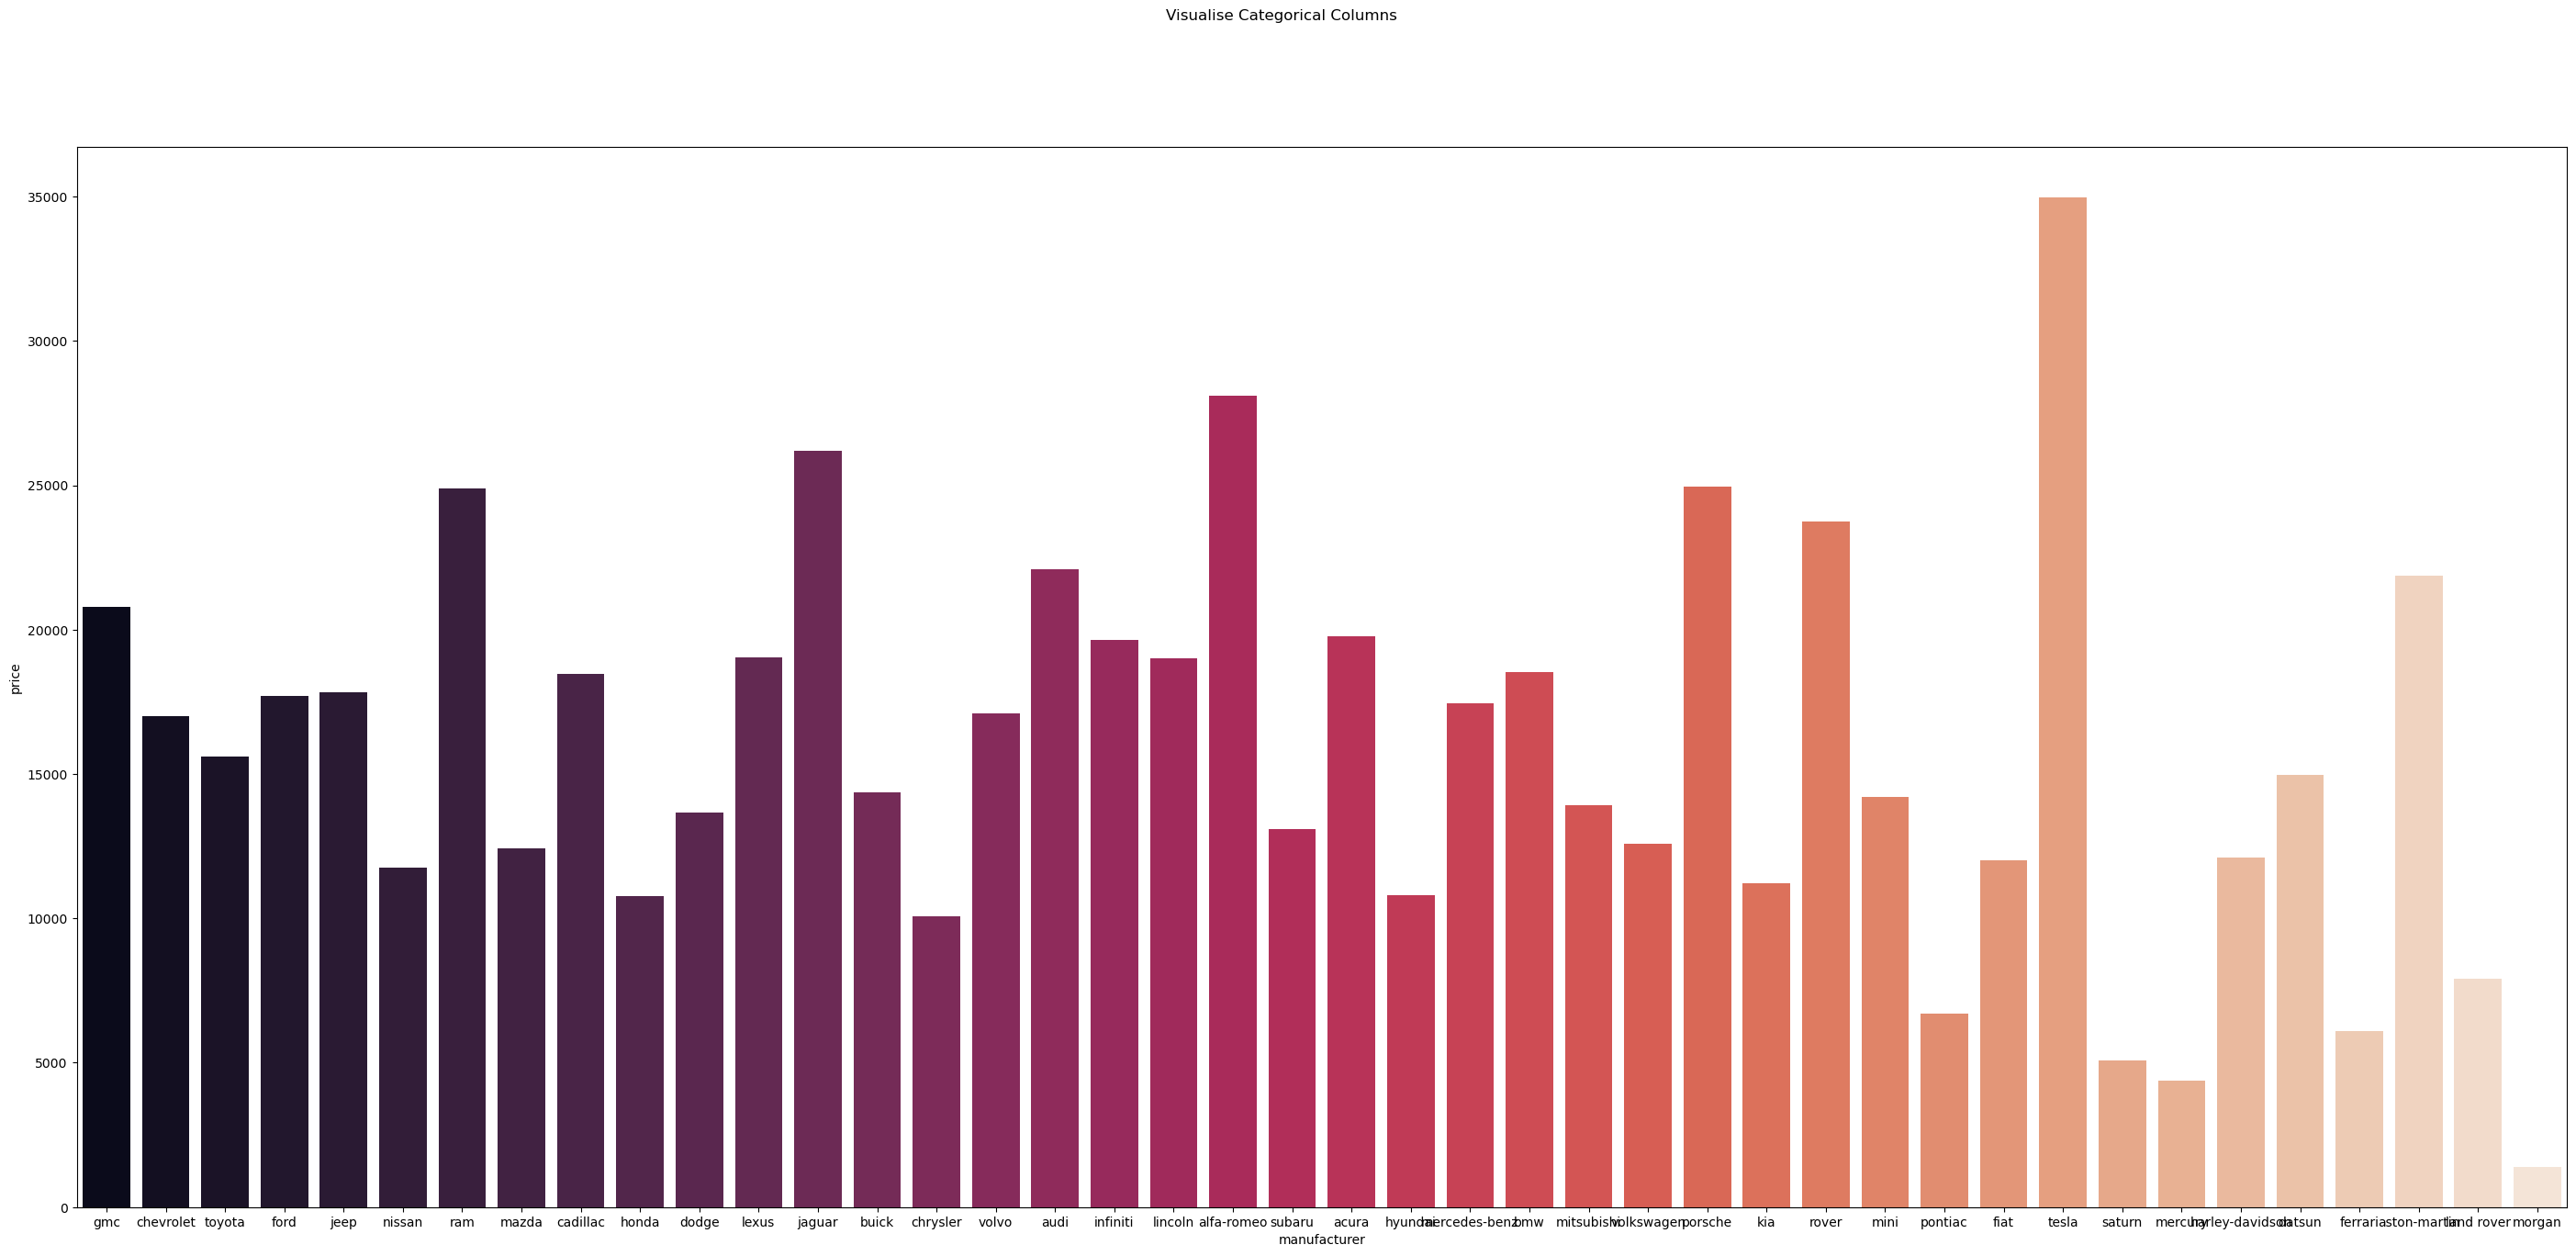

In [22]:
fig, ax = plt.subplots(figsize=(35,15), sharey=True)
fig.suptitle('Visualise Categorical Columns')
sns.barplot(x= df['manufacturer'], y=df['price'], errorbar=None, palette='rocket')

We can observe a correlation between price and high-end car manufacturer such as tesla, jaguar, porsche, rover, aston martin, audi, etc. These car manufacturers also indicate the presence of outliers potentially because these manufacturers produce car models that cost significantly more than others. Nonetheless, a large proportion of the data set is monopolised by low to medium budget car manufacturers.

# Deep Dive into Data

How is condition influenced by mileage?

<AxesSubplot: xlabel='condition', ylabel='odometer'>

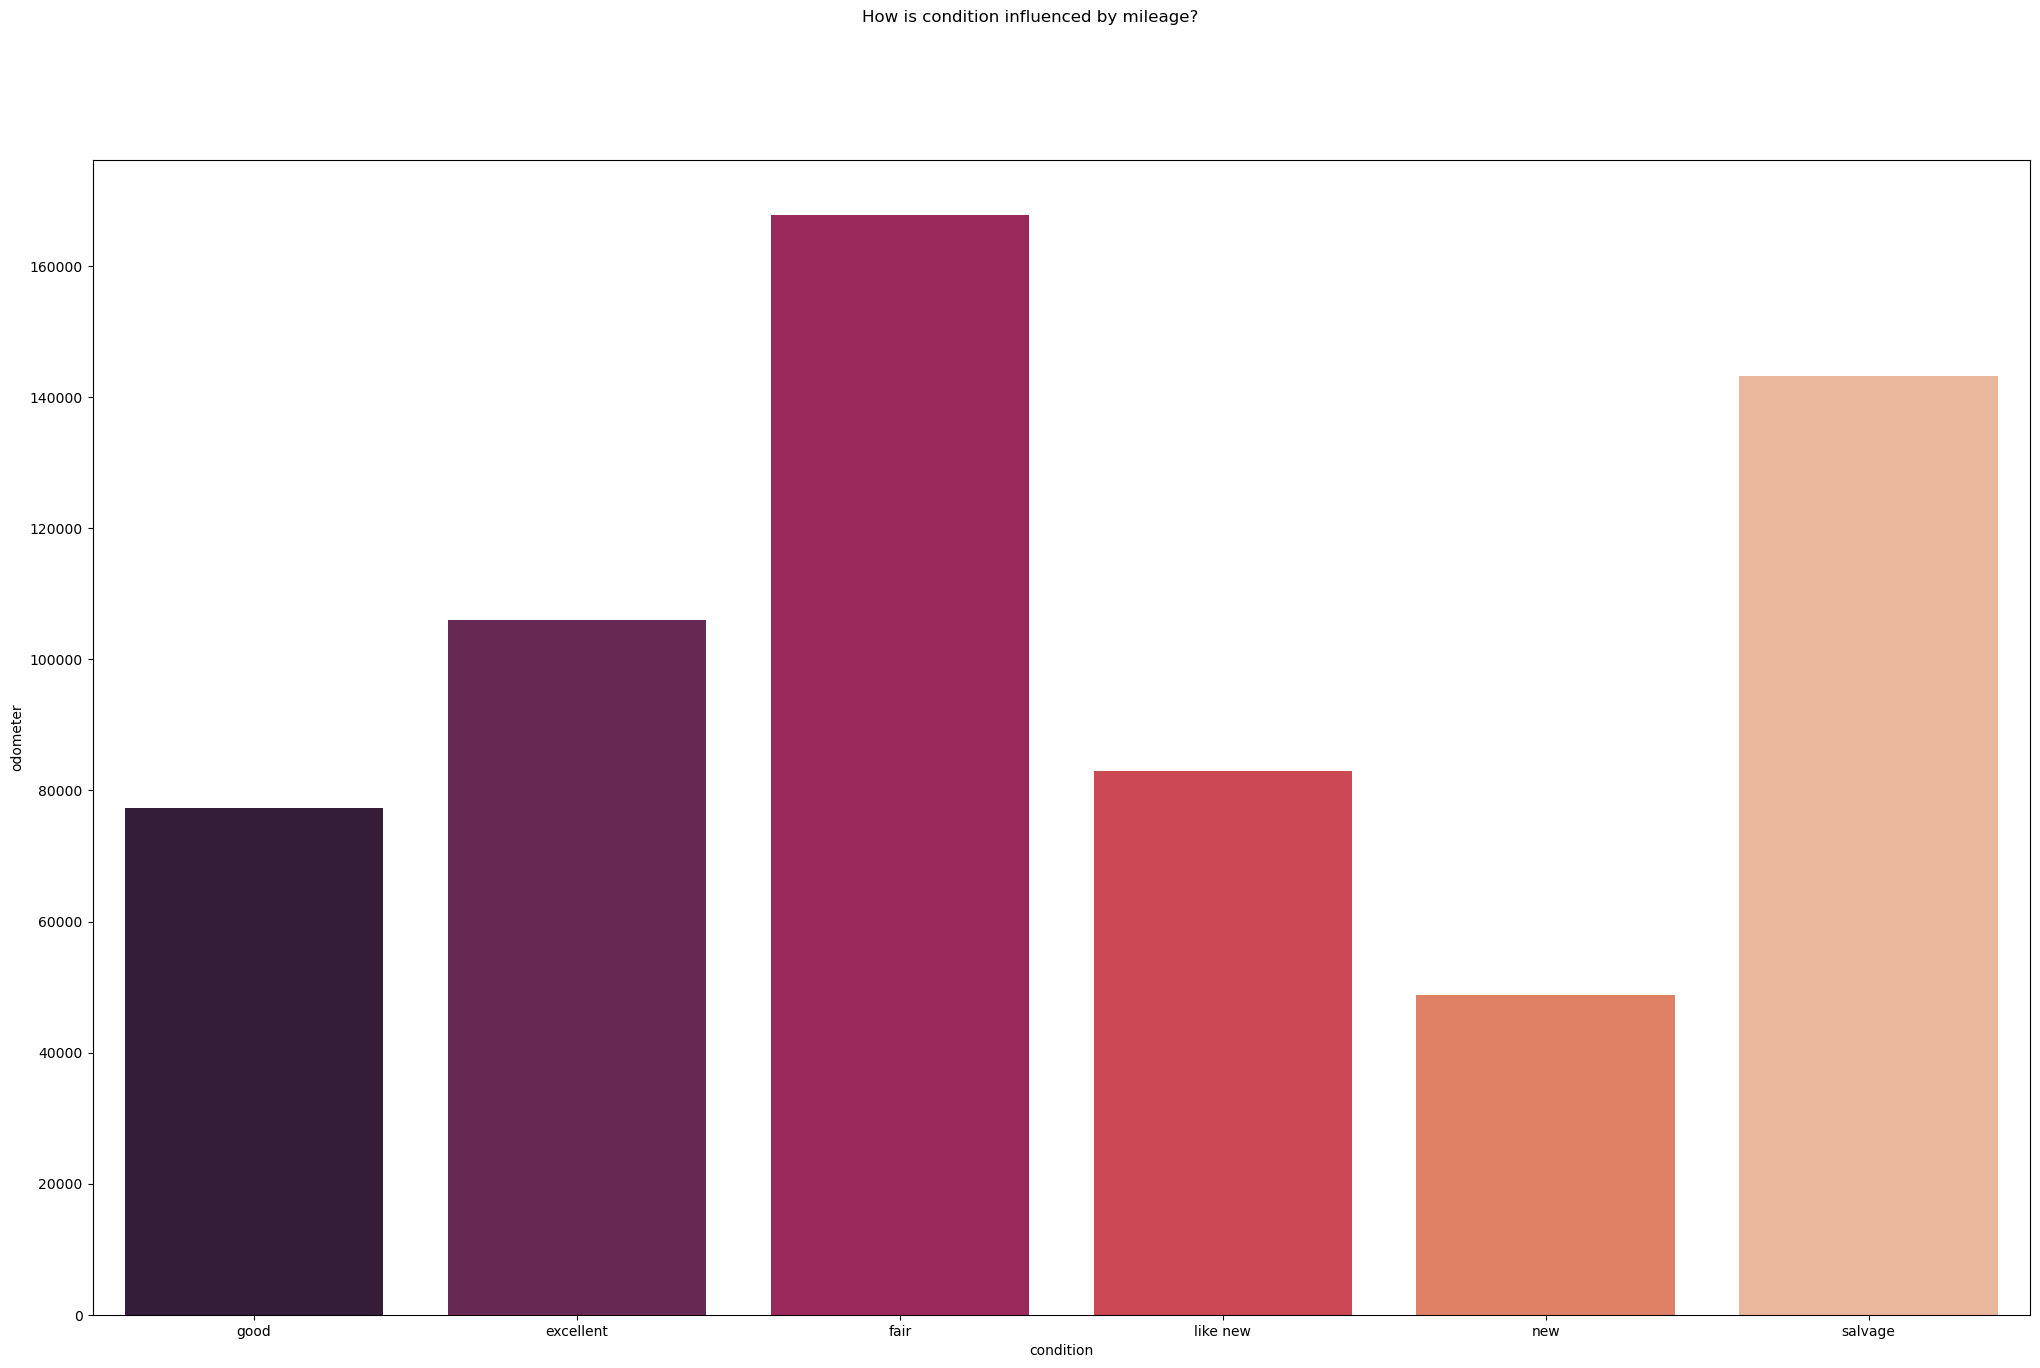

In [23]:
fig, ax = plt.subplots(figsize=(25,15), sharey=True)
fig.suptitle('How is condition influenced by mileage?')
sns.barplot(x= df['condition'], y=df['odometer'], errorbar=None, palette='rocket')

What is the average mileage of the car before it is sold?

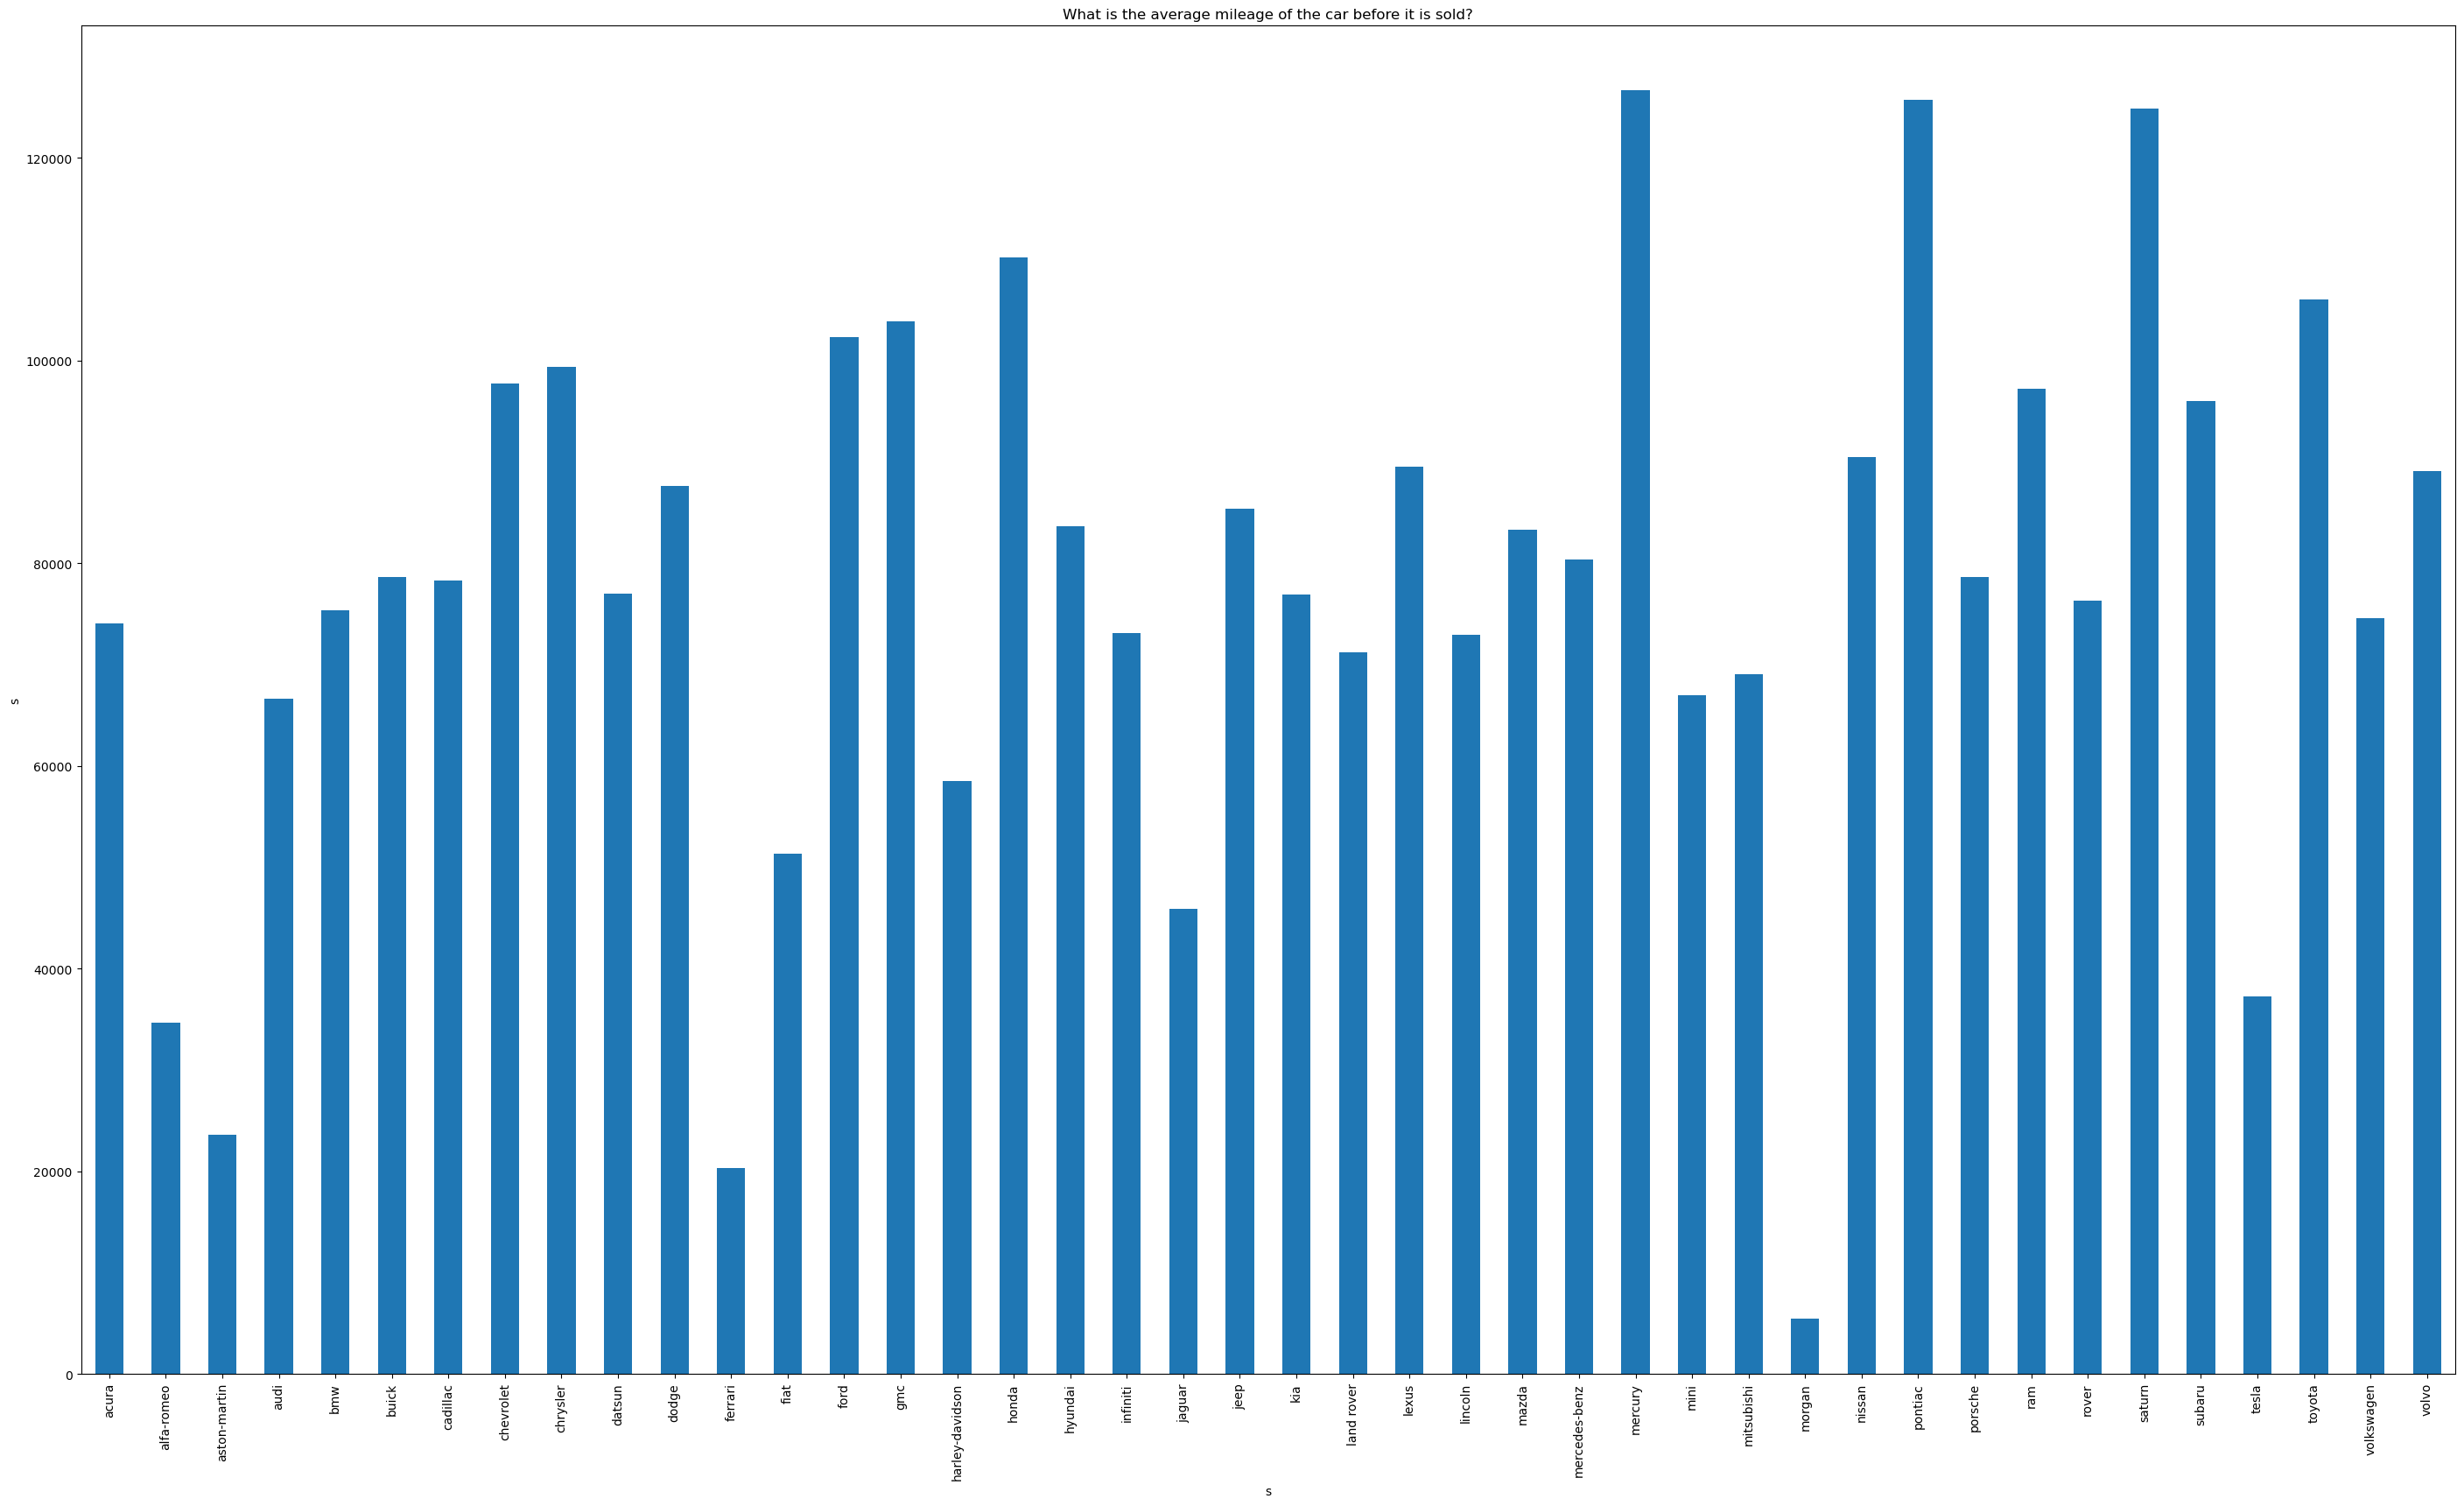

In [24]:
fig, ax = plt.subplots(figsize=(35,20), sharey=True)
Company_Kilometers_Driven = df.groupby('manufacturer').odometer.mean()
Company_Kilometers_Driven.plot(kind='bar')
plt.xlabel("s")
plt.ylabel("s")
plt.title("What is the average mileage of the car before it is sold?")
plt.show()

# Data Pre-Processing


Based on the situation that there are plenty of null values in our dataset and these missing values are hard to fill with accurate guesses. Since none of the numerical variables have missing values, we can focus on adjusting only the categorical variables. To do this we take the following three actions:

For columns that have > 40% in missing values, we remove the whole column because too many missing values .

For columns that have < 40%, we replace the values by categorising it as 'other' instead of removing more data.



<Figure size 1000x600 with 0 Axes>

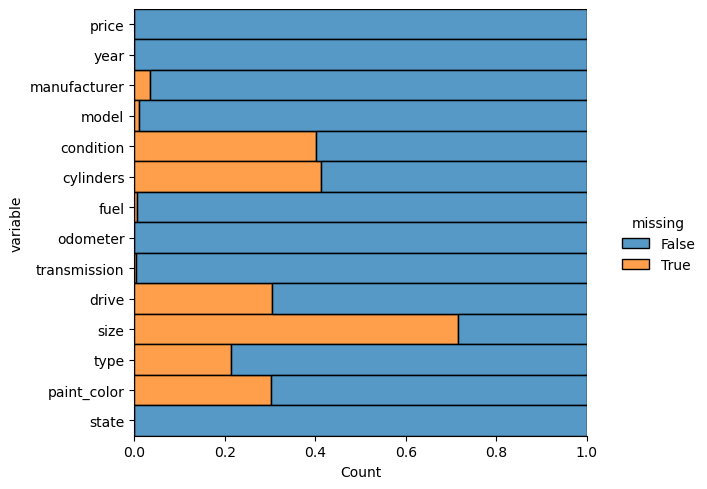

In [25]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

In [26]:
null_values = df.isna().sum()

def na_filter(na, threshold = 0.4):
    column = []
    for i in na.keys():
        if na[i]/df.shape[0] < threshold:
            column.append(i)
    return column

df = df[na_filter(null_values)]
df.columns

Index(['price', 'year', 'manufacturer', 'model', 'fuel', 'odometer',
       'transmission', 'drive', 'type', 'paint_color', 'state'],
      dtype='object')

Remaining columns after removing any column with >40% missing values. We now replace remaining missing values with 'other'

<Figure size 1000x600 with 0 Axes>

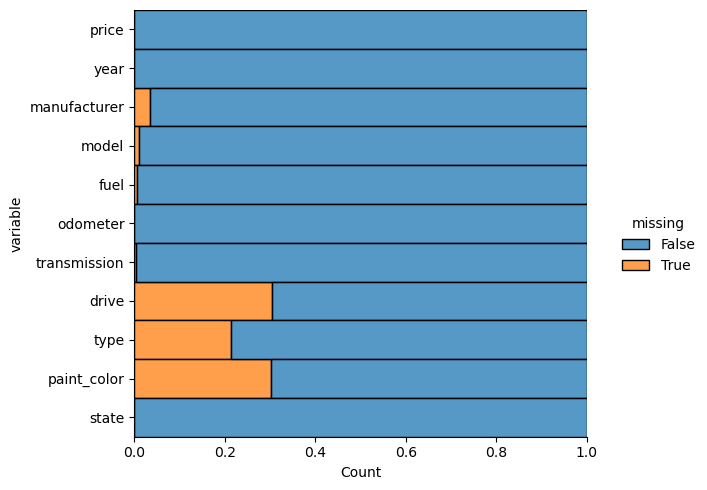

In [27]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

In [28]:
df = df.replace(np.nan, 'other', regex=True)

<Figure size 1000x600 with 0 Axes>

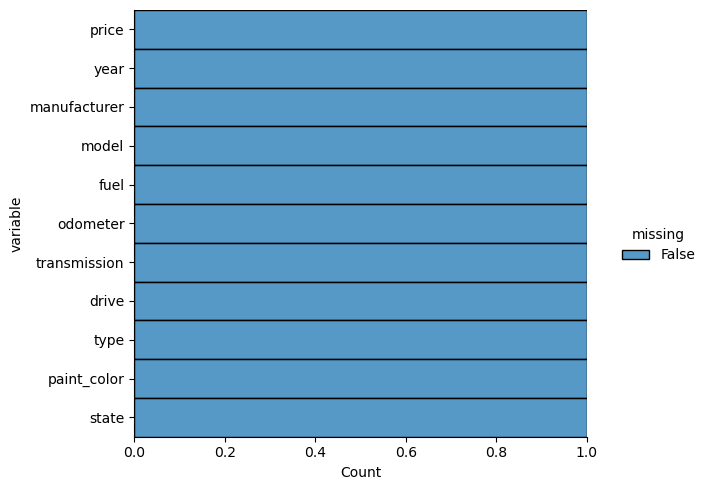

In [29]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

In [30]:
df.head()

,price,year,manufacturer,model,fuel,odometer,transmission,drive,type,paint_color,state
27,33590,2014.0,gmc,sierra 1500 crew cab slt,gas,57923.0,other,other,pickup,white,al
28,22590,2010.0,chevrolet,silverado 1500,gas,71229.0,other,other,pickup,blue,al
29,39590,2020.0,chevrolet,silverado 1500 crew,gas,19160.0,other,other,pickup,red,al
30,30990,2017.0,toyota,tundra double cab sr,gas,41124.0,other,other,pickup,red,al
31,15000,2013.0,ford,f-150 xlt,gas,128000.0,automatic,rwd,truck,black,al


In [31]:
df.nunique(axis=0)

price            14309
year                52
manufacturer        43
model            26959
fuel                 5
odometer        102580
transmission         3
drive                4
type                13
paint_color         13
state               51
dtype: int64

Within categorical variables, we see that there are 26959 unique entries under model. We'll drop this column from our dataset because the large number of distinct values increases the dimensionality in our dataset especially when we proceed to encoding our categorical variables. It would only increase our dataset by 26959 variables. Additionally, since we have 'manufacturer', whereby one model can only belong to one manufacturer, a certain element of multicolinearity will be reintroduced as there is surely a relationship between car's make and its model.

In [32]:
df = df.drop(columns=['model'])

Since we can only select four predictor variables, we will use year, odometer, manufacturer, and type.

In [33]:
df = df.drop(columns=['transmission','fuel','state','paint_color','drive'])

'Condition' was the only variable that was ordinal but since we removed it for having >40% missing values, the remaining variables are nominal (order is irrelevant). For this reason, we create dummy variables for one-hot encoding of categorical variables instead of any other form of encoding. This prevents the model from identifying any order between the values of the variables.

In [34]:
catColumns = ['manufacturer','type']
for column in catColumns: 
    column = pd.get_dummies(df[column],drop_first=True) 
    df = pd.concat([df,column],axis=1)
df = df.drop(columns = catColumns) 

# Create a Train-Test Split


In [35]:
X_train, X_test, y_train, y_test= train_test_split(df.drop('price',axis=1), 
                                                    df['price'],test_size=0.20, 
                                            random_state=5564)

In [36]:
df = X_train.copy()
df_test = X_test.copy()

In [37]:
df_train_labels = y_train.copy()
df_test_labels = y_test.copy()

We standardize our numerical variables within the train and test set so that they can be evaluated equally with our categorical variables. We perform this only after the split because if we did it before the train-test split, the pre-processed standardization would introduce a data leak if the data is split i.e. the global norm/mean would be indirectly introduced in the test set.

In [38]:
scaler = StandardScaler()

for column in ['year','odometer']:
    df[column] = scaler.fit_transform(df[column].values.reshape(-1,1))

We perform the standardization of the train and test seperately to prevent any carryover.



In [39]:

std_Scaler = StandardScaler()

for column in ['year','odometer']:
    df_test[column] = scaler.fit_transform(df_test[column].values.reshape(-1,1))

Lastly, we check that both our train and test sets have identical number of variables from the encoding and its values are comparable across the variables.

In [40]:
df.head()

,year,odometer,alfa-romeo,aston-martin,audi,bmw,buick,cadillac,chevrolet,chrysler,...,coupe,hatchback,mini-van,offroad,other,pickup,sedan,truck,van,wagon
226291,-0.828528,-0.125693,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
408968,-0.828528,1.447829,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
92590,-0.545020,0.273422,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17370,-0.261513,2.212647,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
322921,-0.686774,1.030101,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_test.head()

,year,odometer,alfa-romeo,aston-martin,audi,bmw,buick,cadillac,chevrolet,chrysler,...,coupe,hatchback,mini-van,offroad,other,pickup,sedan,truck,van,wagon
228759,-0.969290,0.414029,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
386312,0.449902,0.142840,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7466,0.875660,-0.848805,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
415324,0.449902,0.047126,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
136507,-4.659189,-1.324774,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0



# Building our Model

In [42]:
Acc = pd.DataFrame(index=None, columns=['Model','Mean Absolute Error','Root Mean Squared Error', 'Accuracy on Training Set','Accuracy on Testing Set'])

In [43]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(df,df_train_labels)
y_pred = rf.predict(df_test)

In [44]:
name = 'RandomForestRegressor'
MAE = round(metrics.mean_absolute_error(df_test_labels,y_pred),2)
RMSE = np.sqrt(metrics.mean_squared_error(df_test_labels,y_pred))
train_accuracy = rf.score(df,df_train_labels)
test_accuracy = rf.score(df_test,df_test_labels)
Acc = Acc.append({
    'Model': name,
    'Mean Absolute Error': MAE,
    'Root Mean Squared Error': RMSE,
    'Accuracy on Training Set': train_accuracy,
    'Accuracy on Testing Set': test_accuracy
}, ignore_index=True)

/tmp/ipykernel_21469/3027130110.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Acc = Acc.append({


In [45]:
Acc

,Model,Mean Absolute Error,Root Mean Squared Error,Accuracy on Training Set,Accuracy on Testing Set
0,RandomForestRegressor,5746.05,9300.080574,0.948615,0.493762


In [48]:
!jupyter nbconvert --to html usedcars.ipynb

[NbConvertApp] Converting notebook usedcars.ipynb to html
[NbConvertApp] Writing 2537491 bytes to usedcars.html
